In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.6*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [3]:
reload(scoob)
model = scoob.SCOOBM()

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)

model.npix = 256
model.oversample = 32


No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


In [11]:
model.pupil_diam/model.npix

<Quantity 0.02636719 mm>

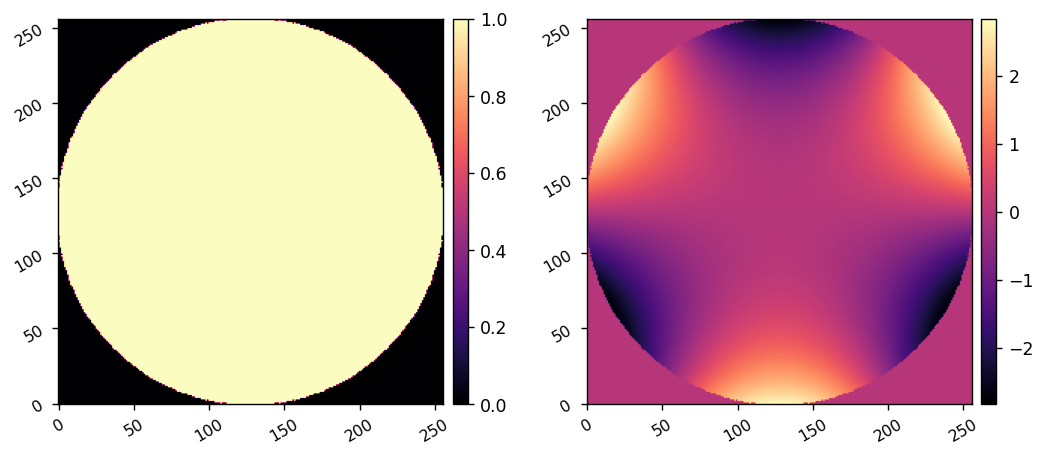

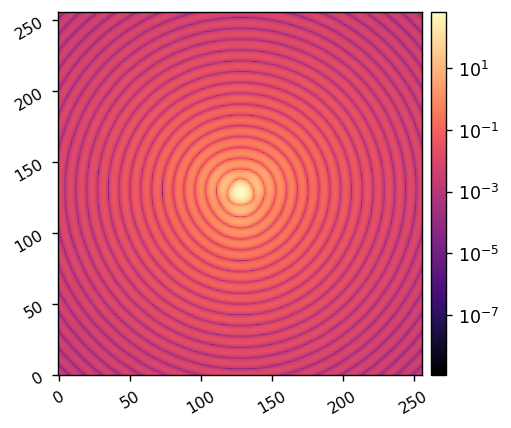

In [5]:
nmodes = 25
wf = poppy.Wavefront(diam=model.pupil_diam, npix=model.npix, oversample=1)
pupil_mask = poppy.CircularAperture(radius=model.pupil_diam/2, name='Pupil').get_transmission(wf).astype(bool)

reload(lina.llowfsc)
zmodes = lina.utils.create_zernike_modes(pupil_mask, nmodes=nmodes+1)[1:]
imshow2(pupil_mask, zmodes[7])

model.WFE = poppy.ArrayOpticalElement(opd=10e-9*zmodes[7], pixelscale=model.pupil_diam.to(u.m)/(model.npix*u.pix))

im = model.snap()
imshow1(im, lognorm=True)
model.reset_dm()




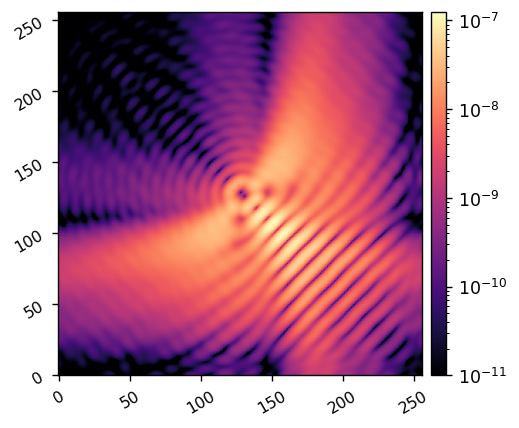

In [6]:
model.WFE = None
model.Imax_ref = model.snap().max()

ref_psf = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()
imshow1(ref_im, lognorm=True, vmin=1e-11)

In [11]:
model.use_llowfsc = True
model.llowfsc_defocus = 1.75*u.mm
model.nllowfsc = 64

model.FPM = vortex
model.LYOT = wfs_lyot_stop


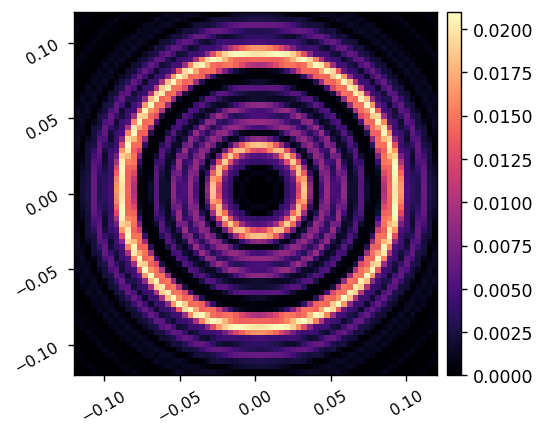

In [12]:
model.reset_dm()
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))

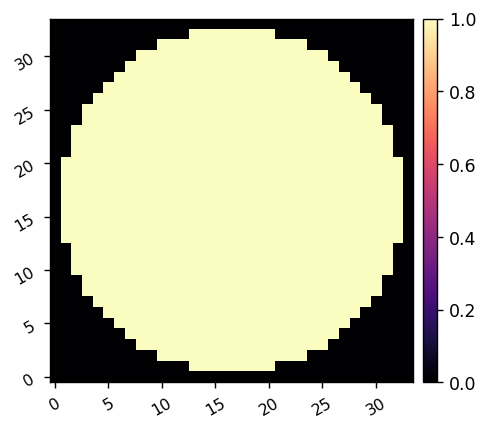

array(812)

In [22]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact-2)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

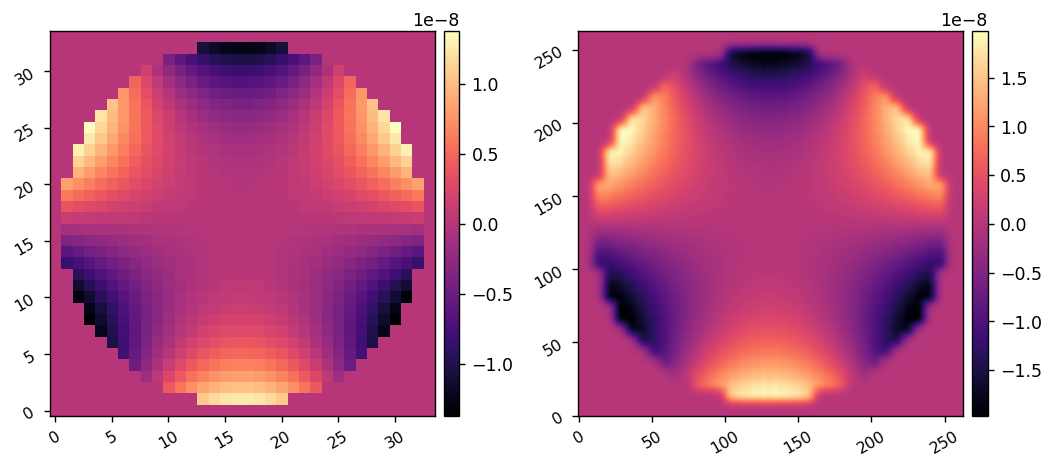

In [23]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface())
model.reset_dm()


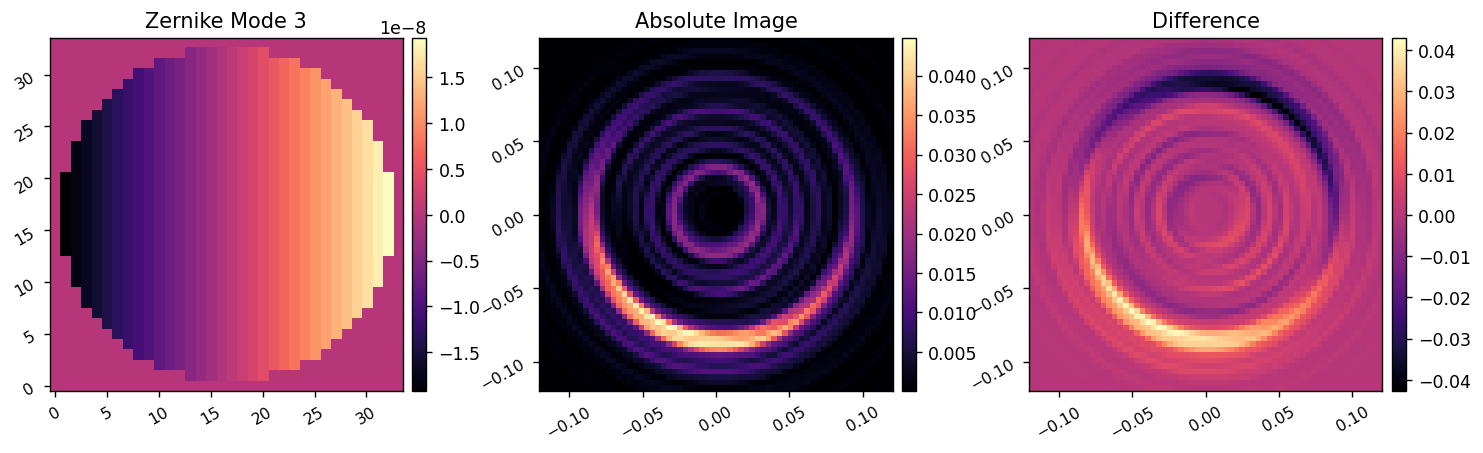

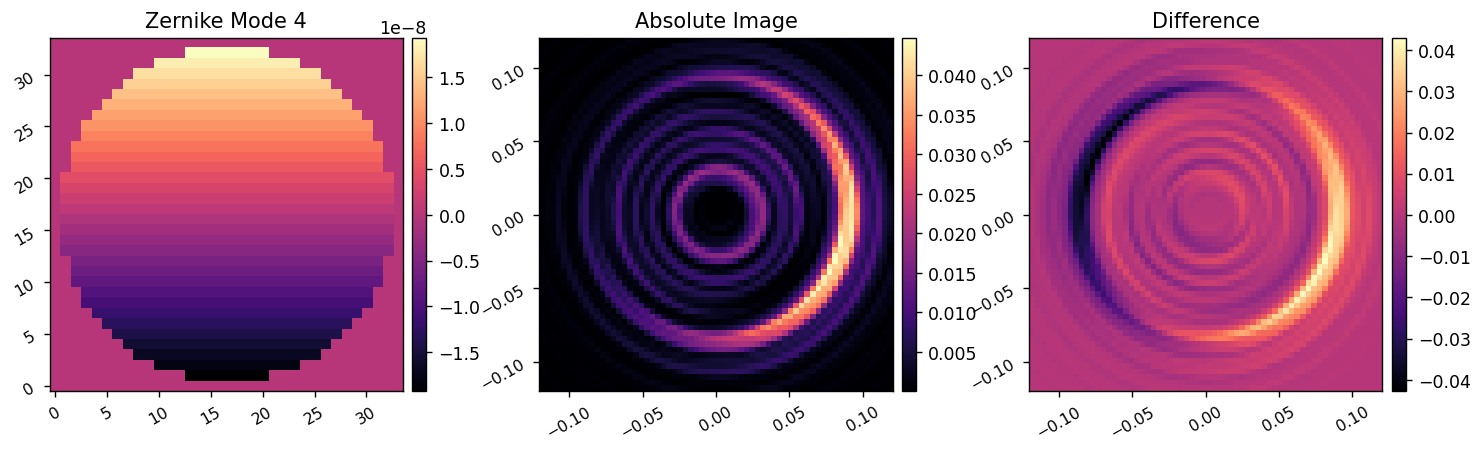

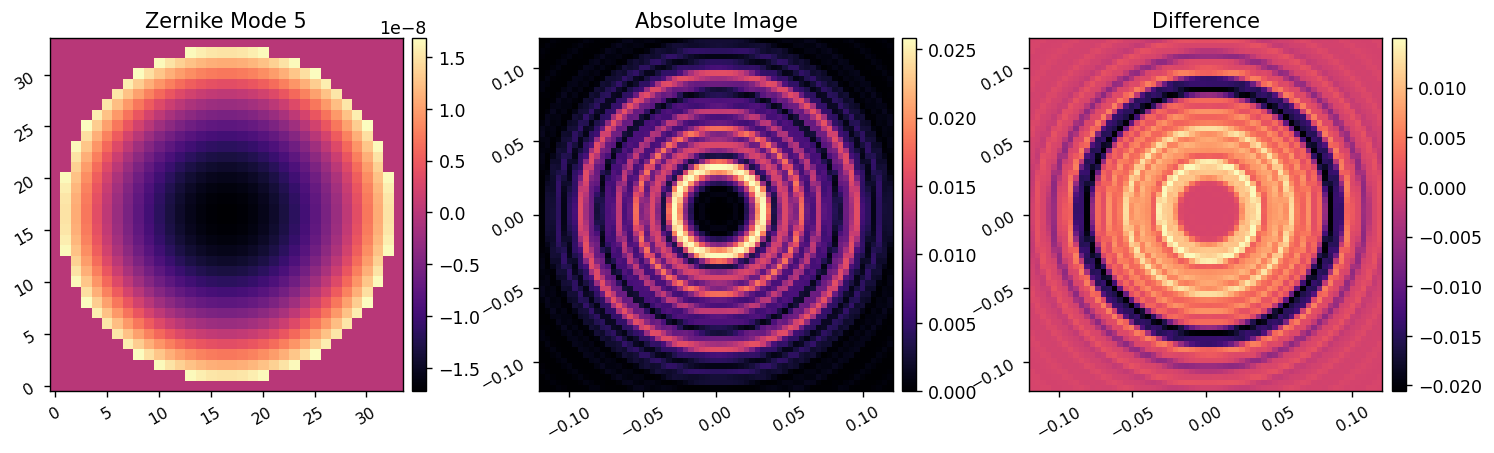

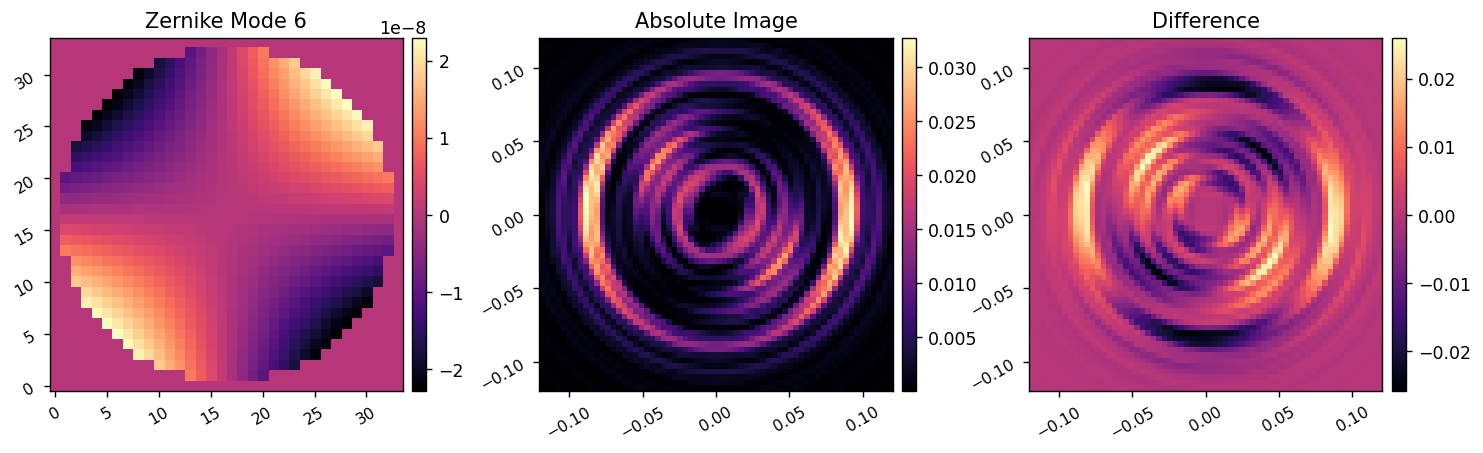

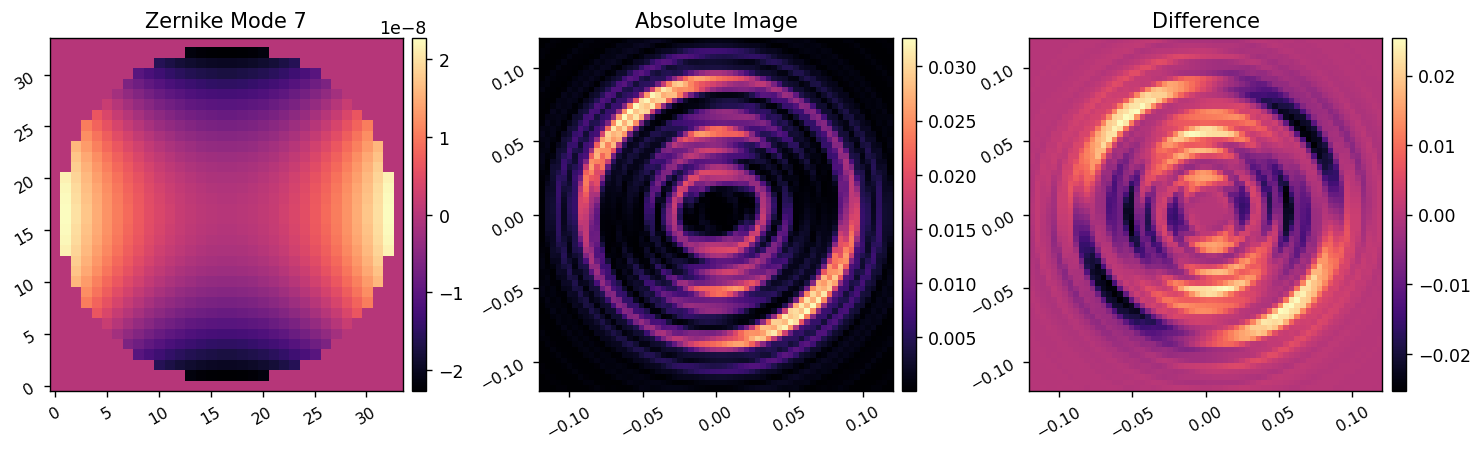

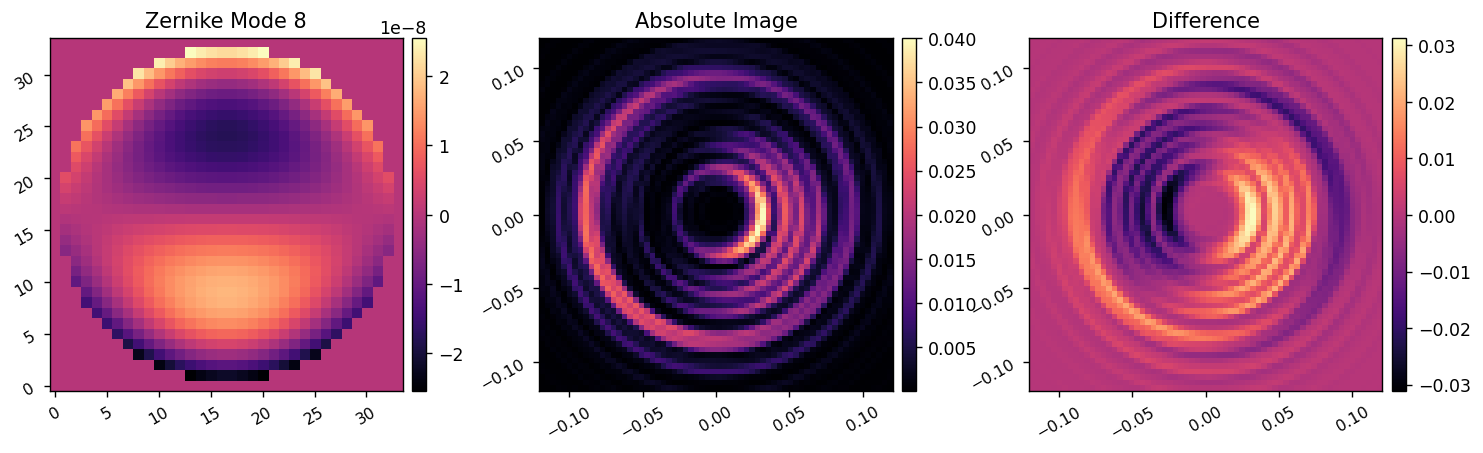

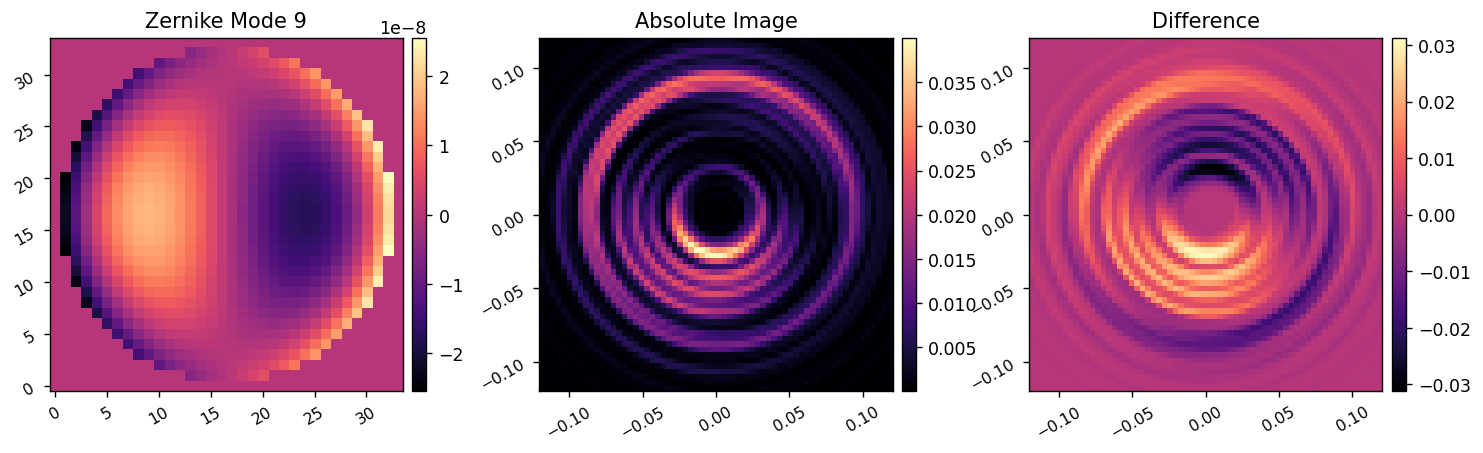

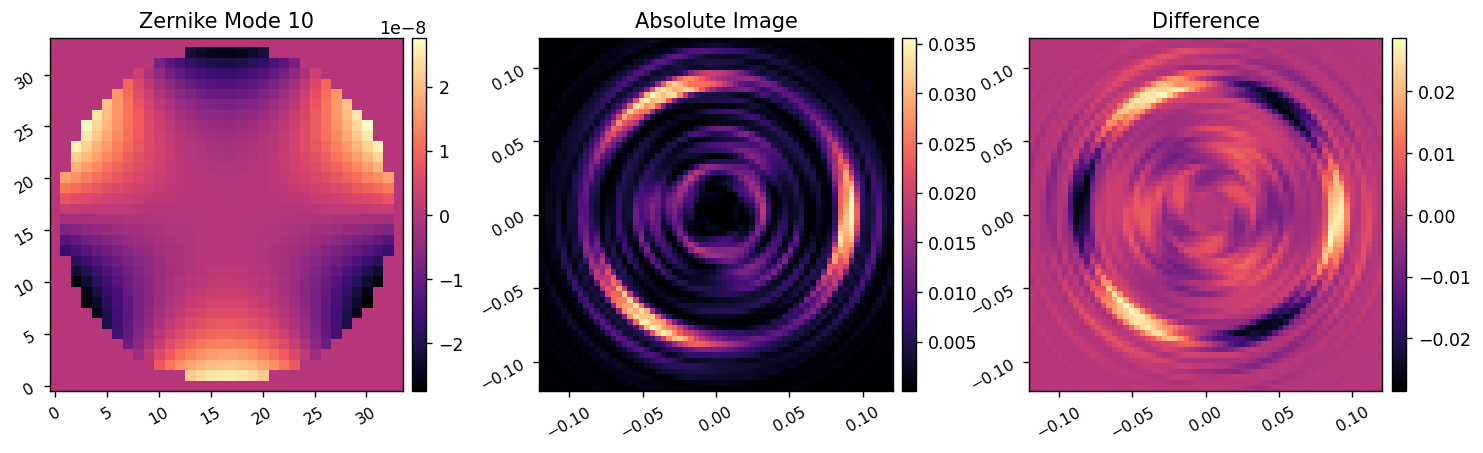

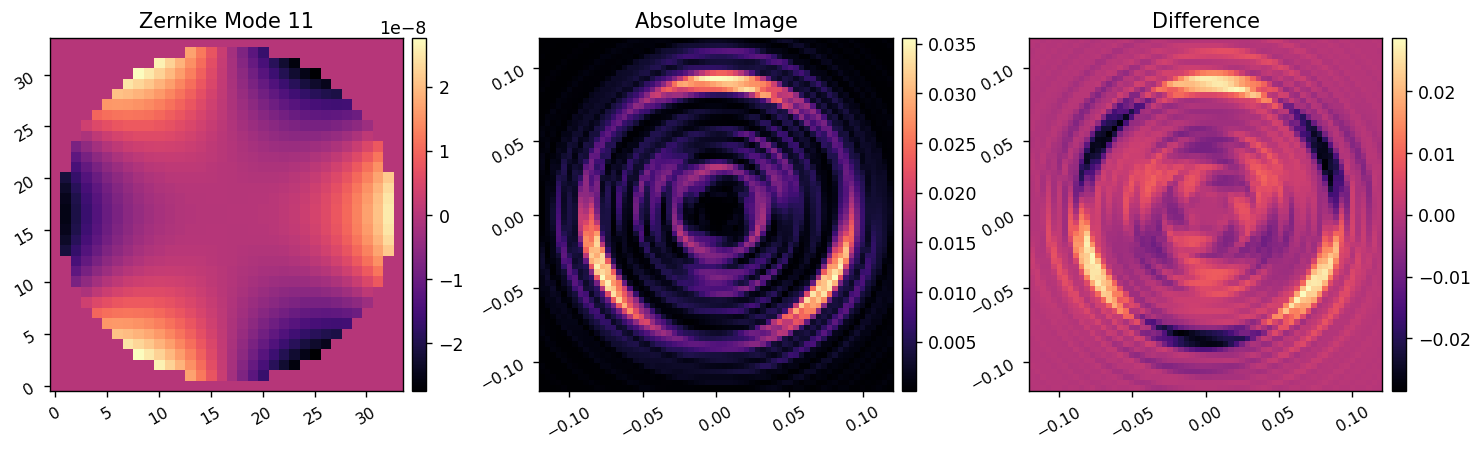

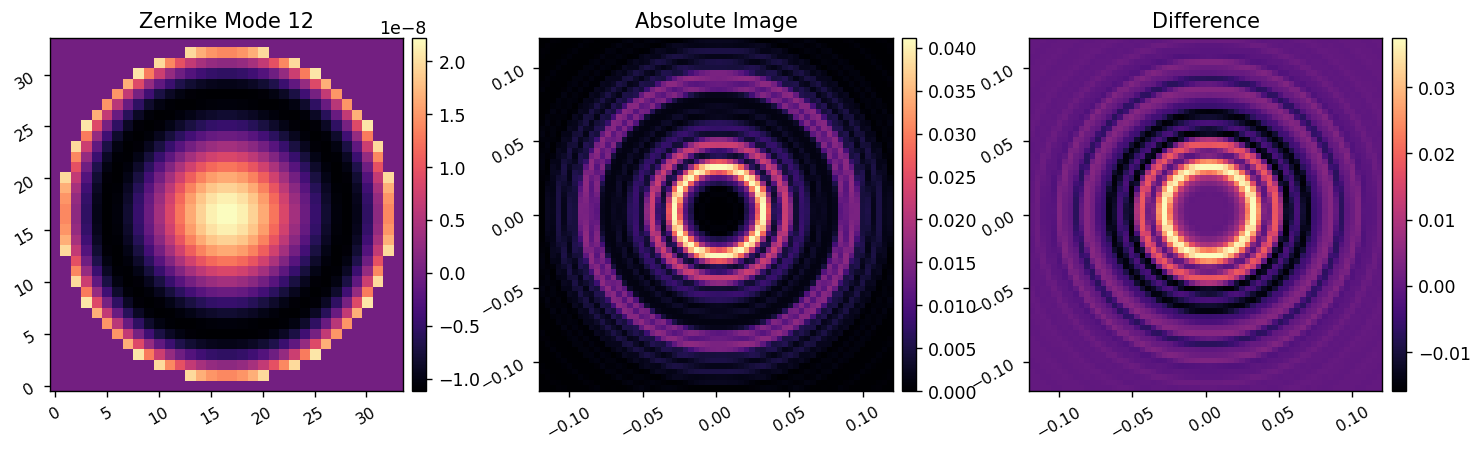

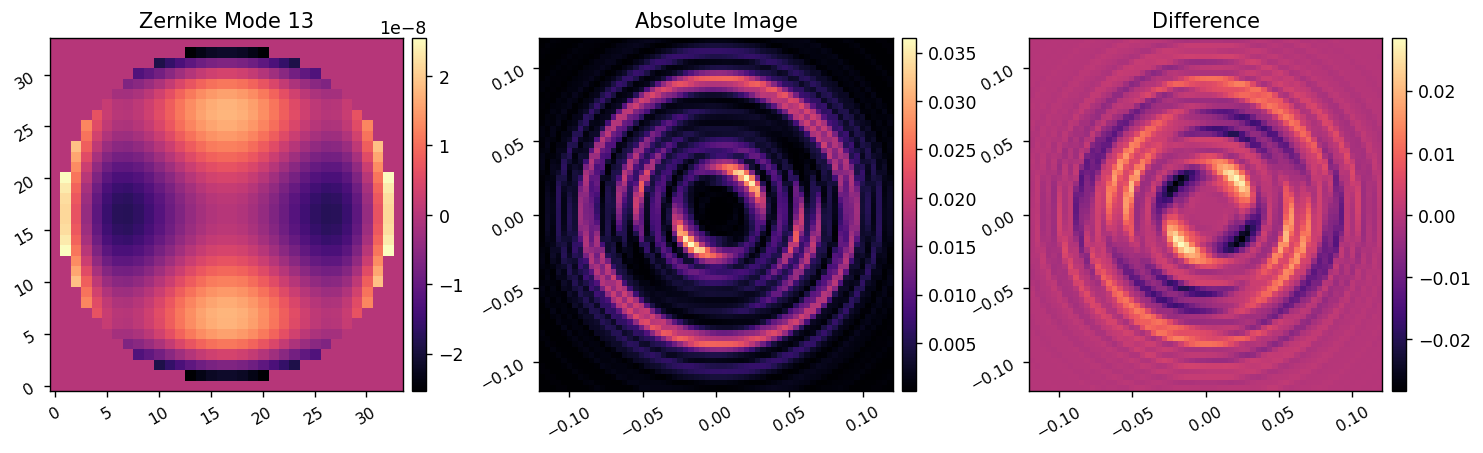

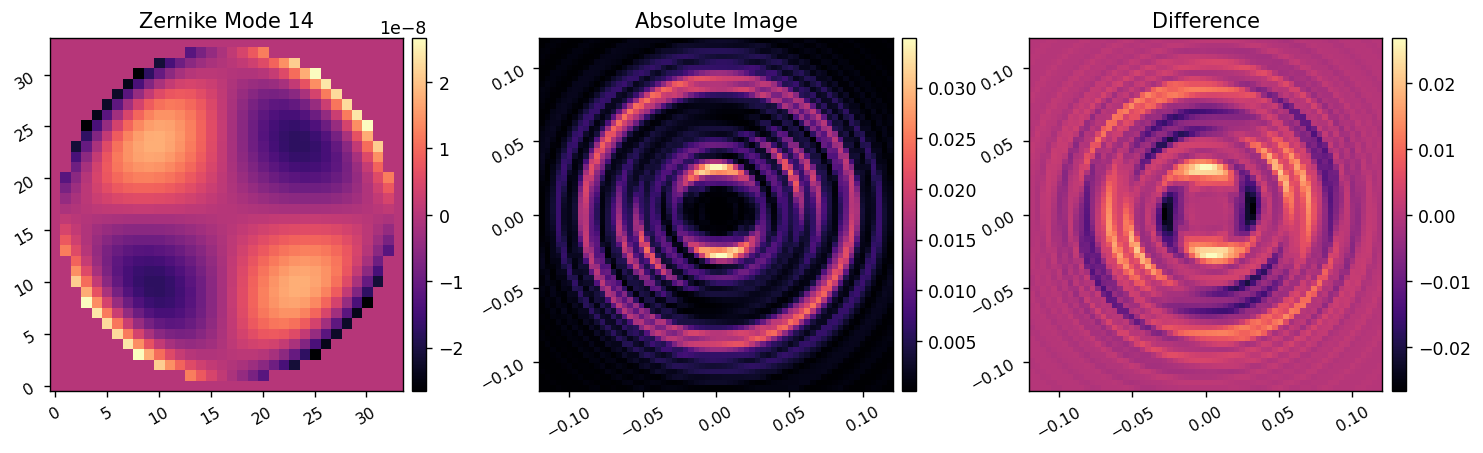

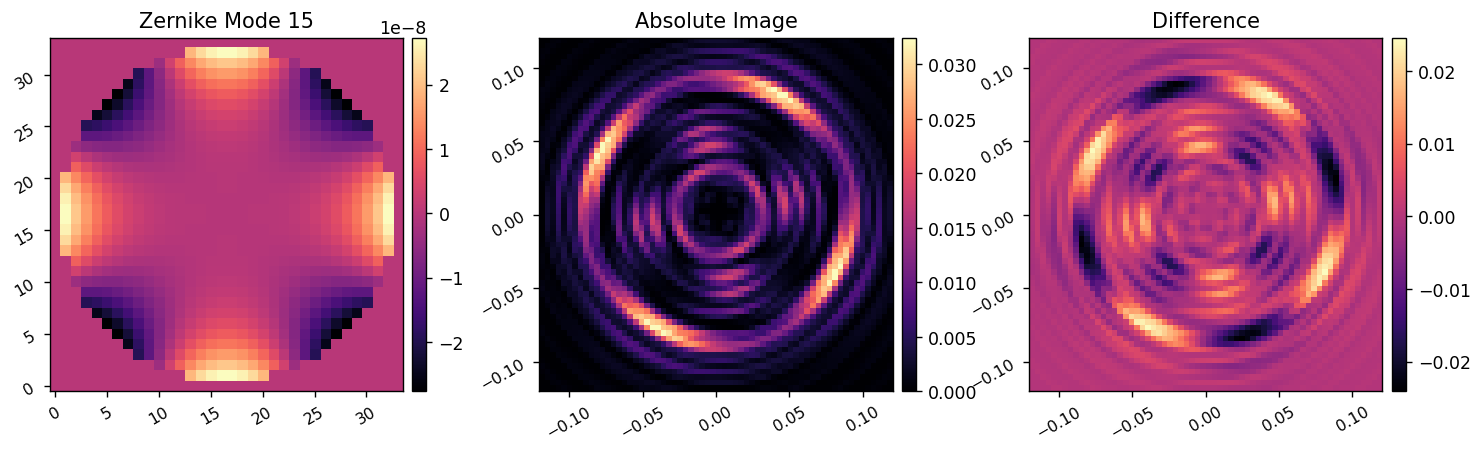

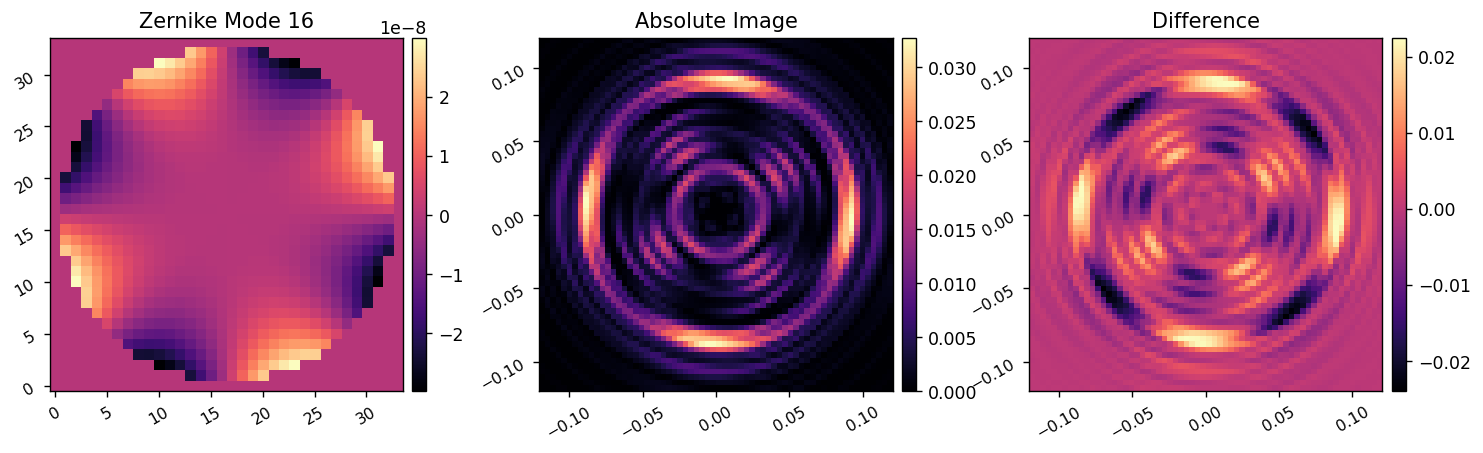

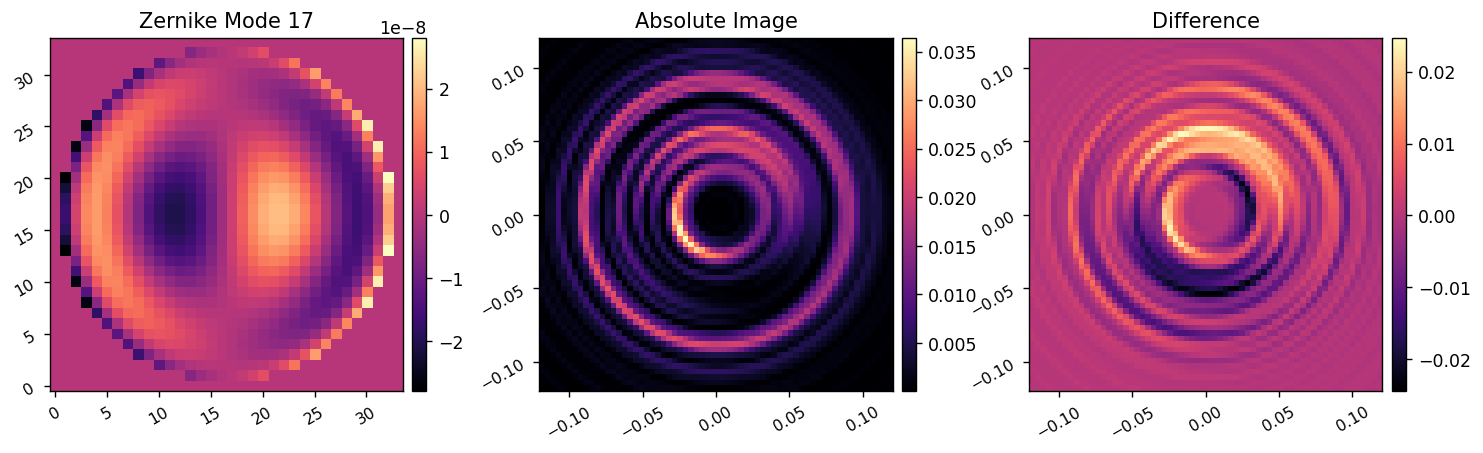

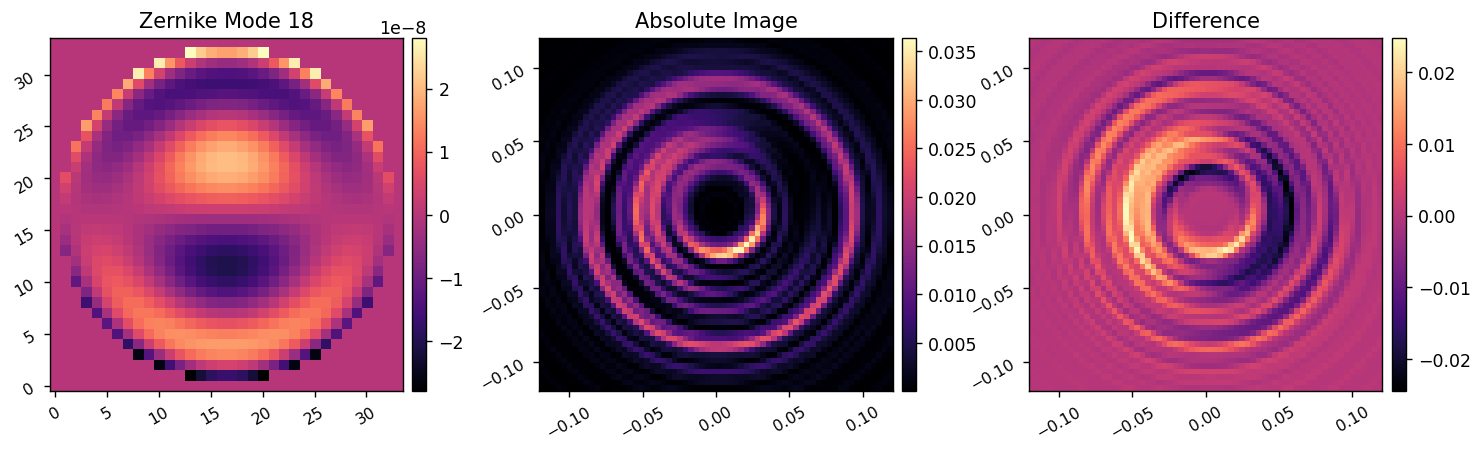

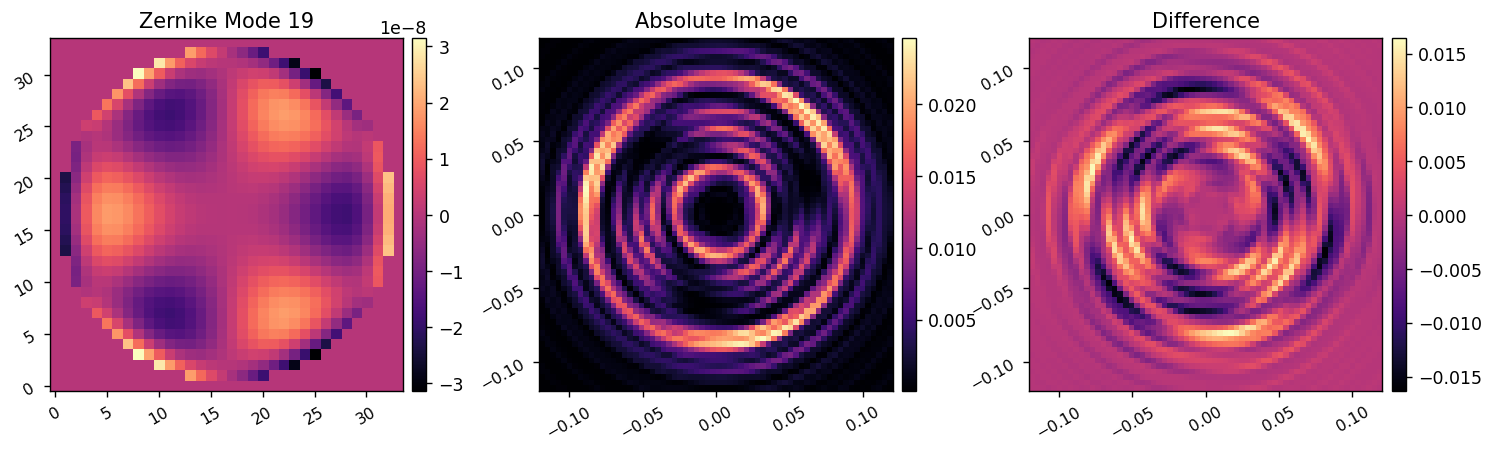

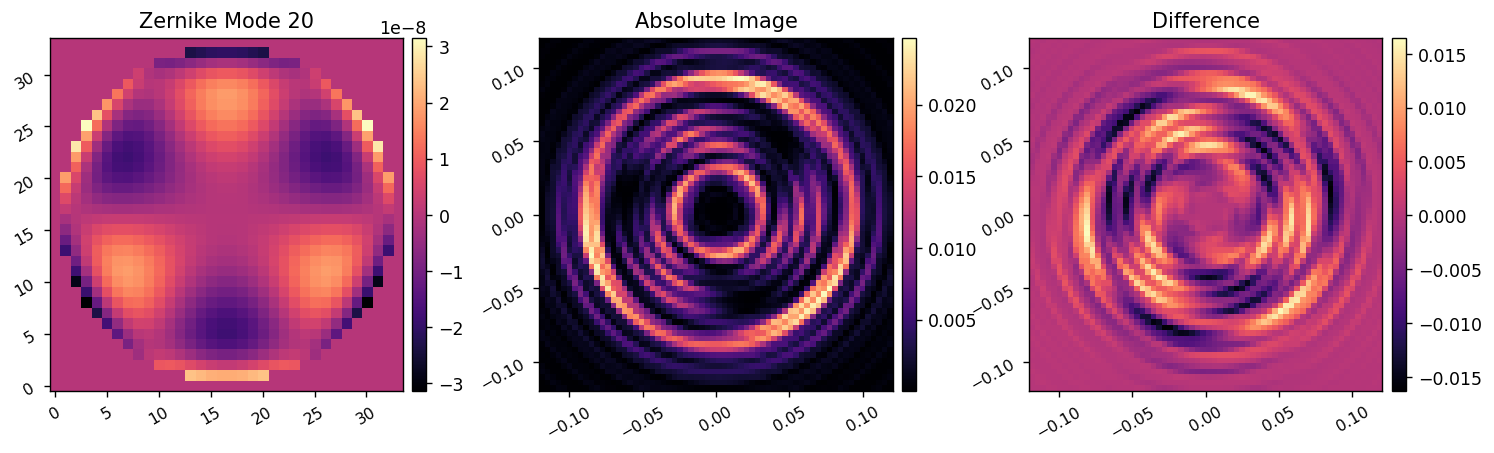

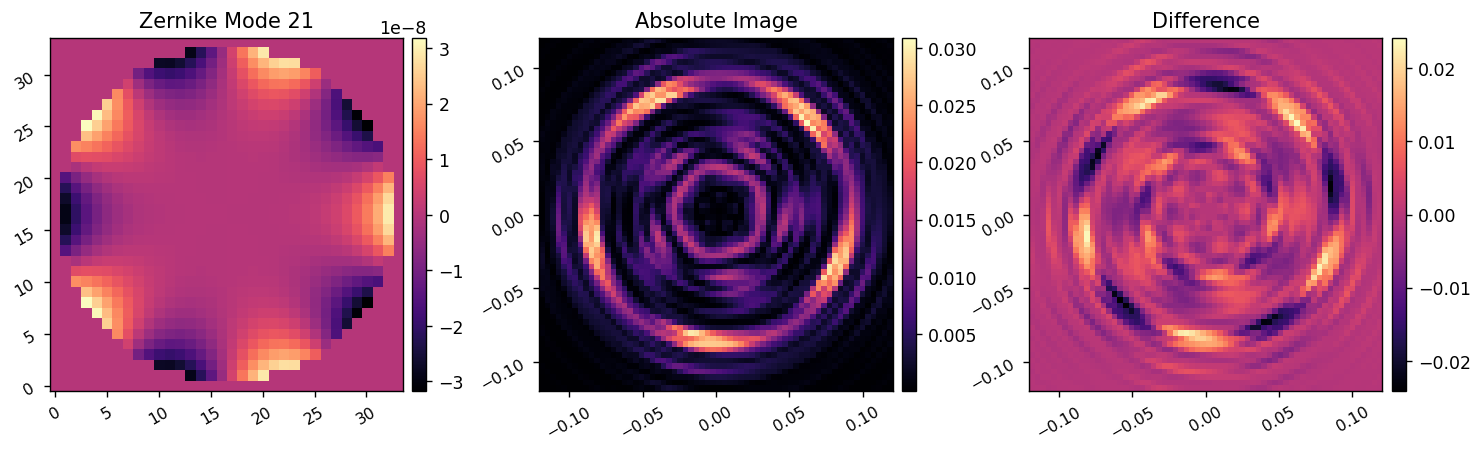

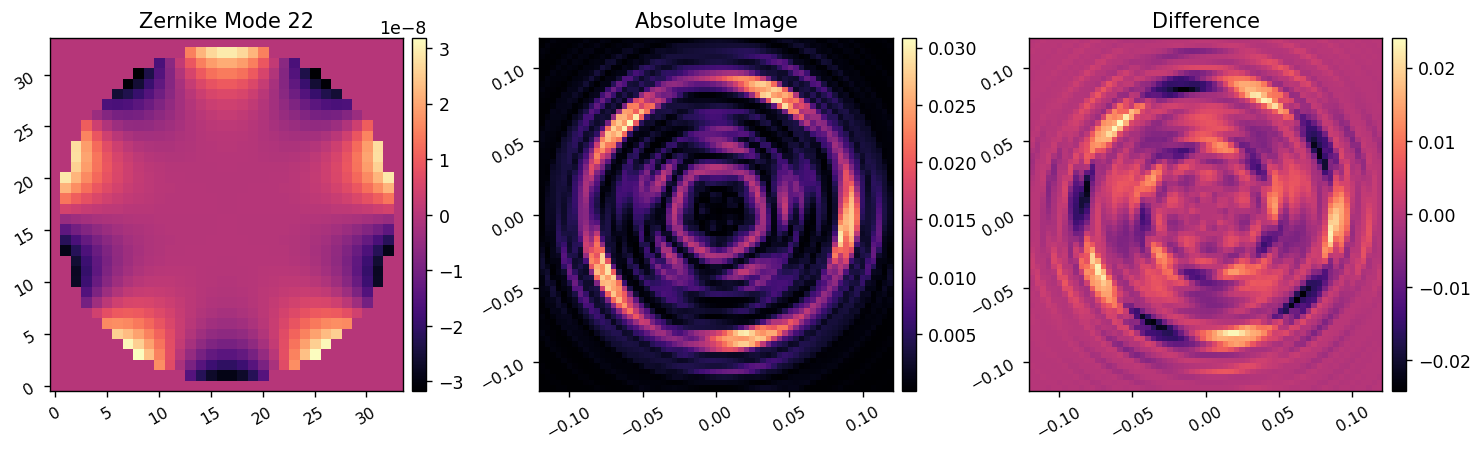

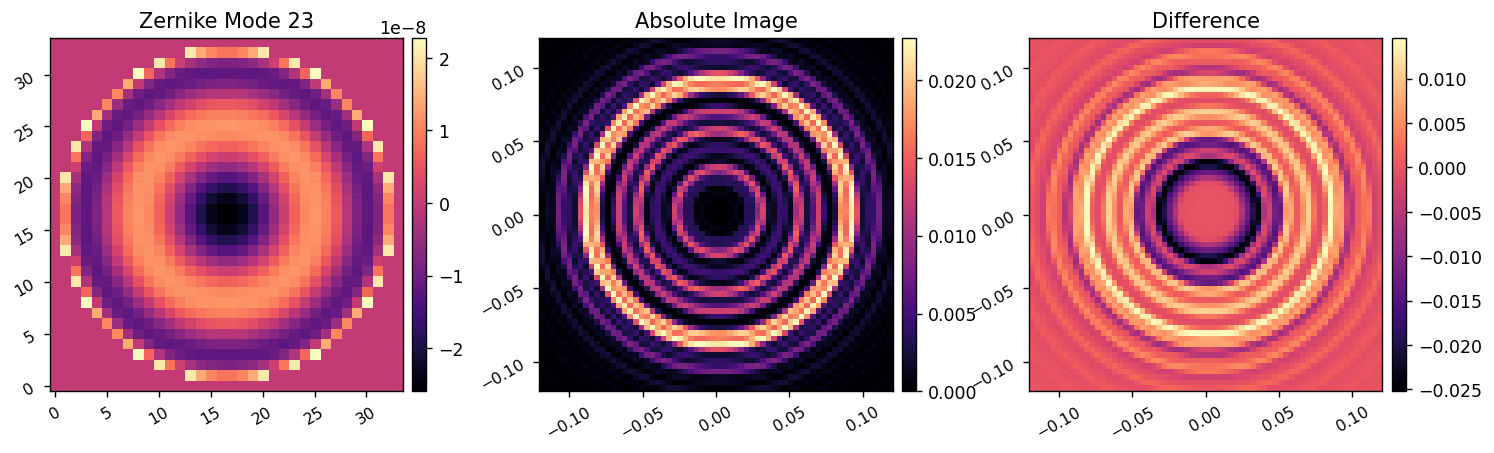

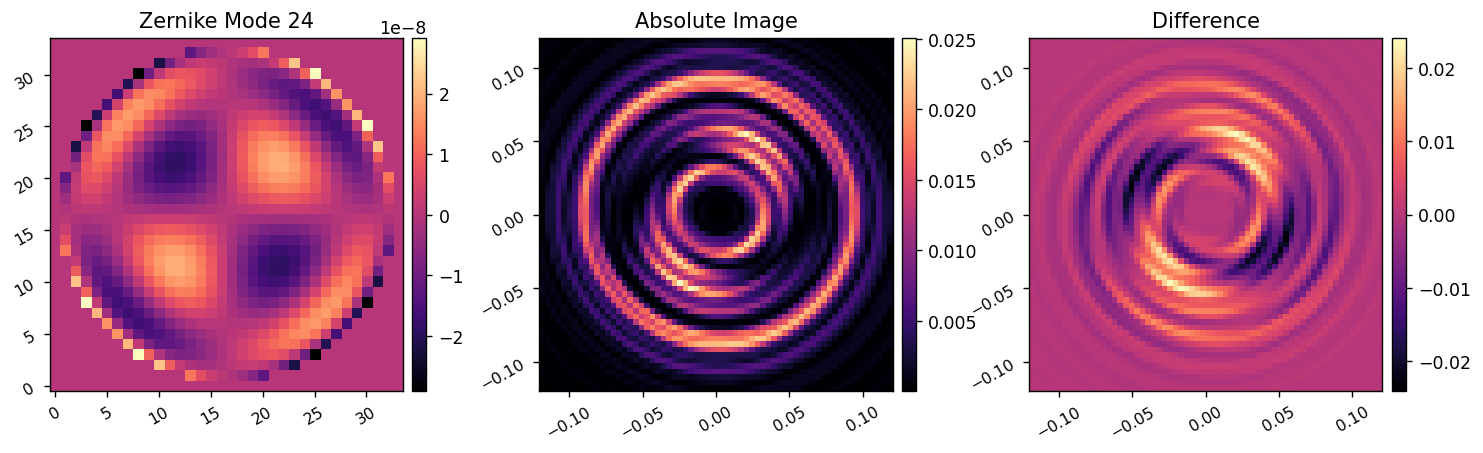

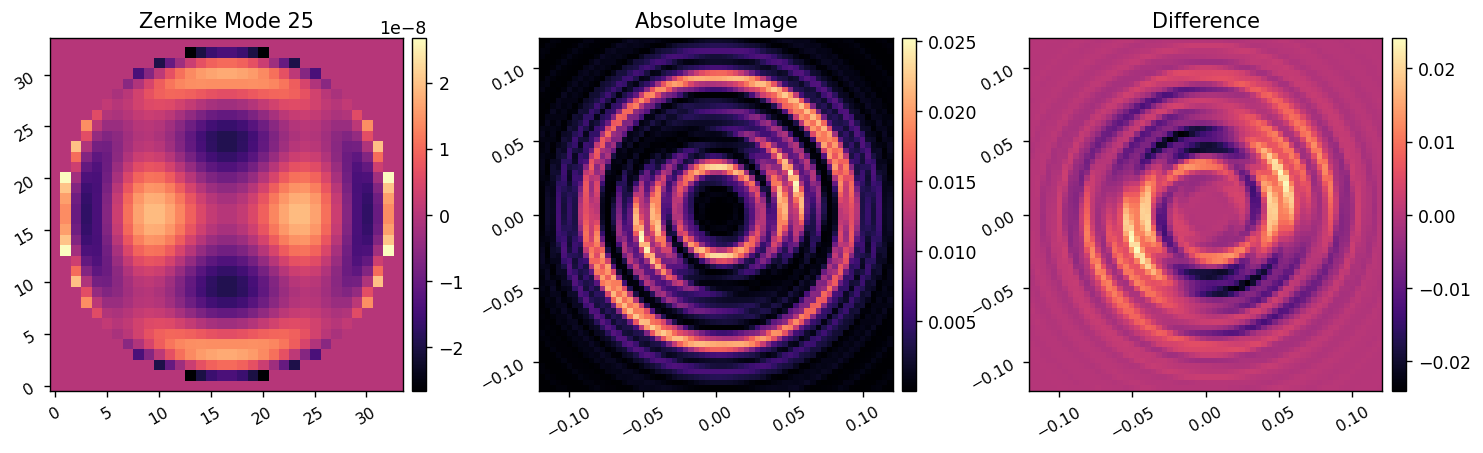

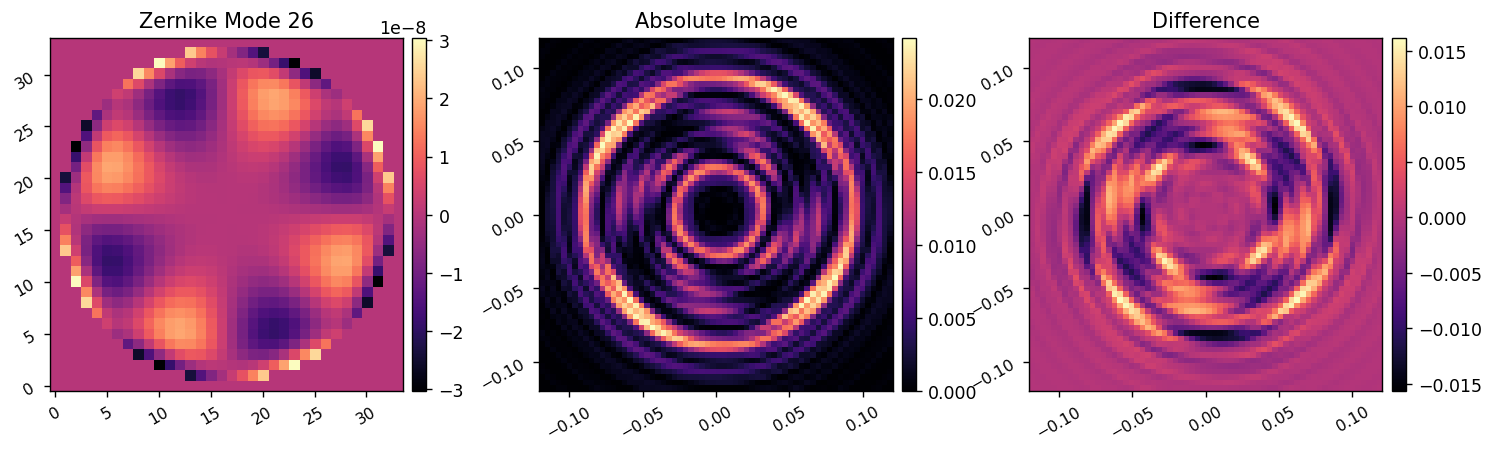

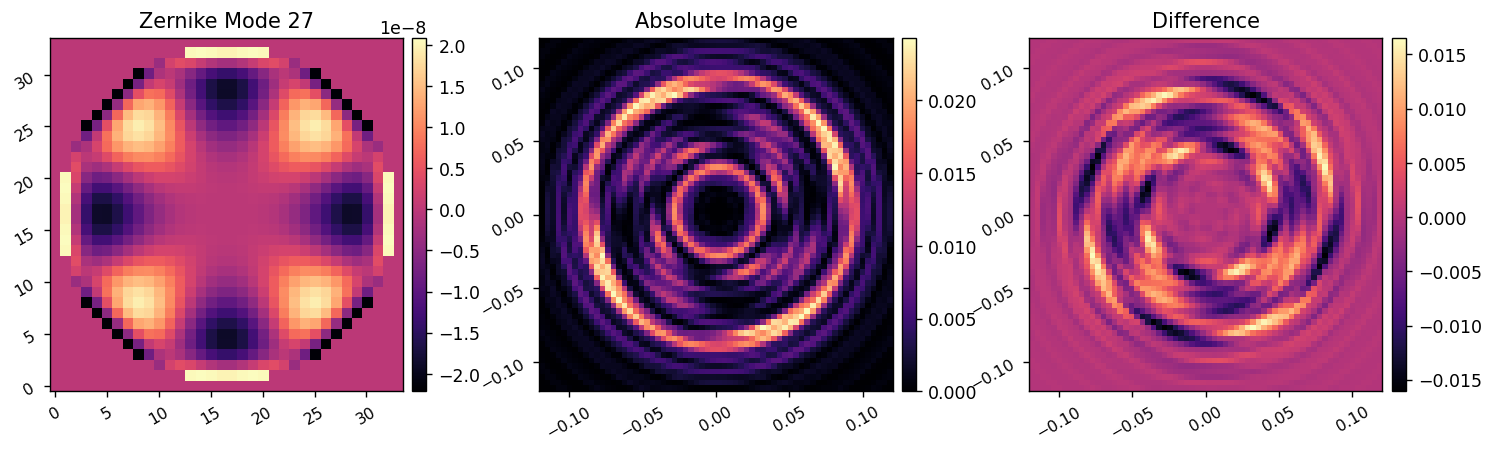

In [24]:
amp = 10e-9

im_ref = model.snap()

responses = xp.zeros((nmodes, model.nllowfsc**2))
for i,mode in enumerate(dm_zernikes):
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+3}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix))

response_matrix = responses.T

In [25]:
zmodes.shape

(25, 256, 256)

6.0746157191380375e-09


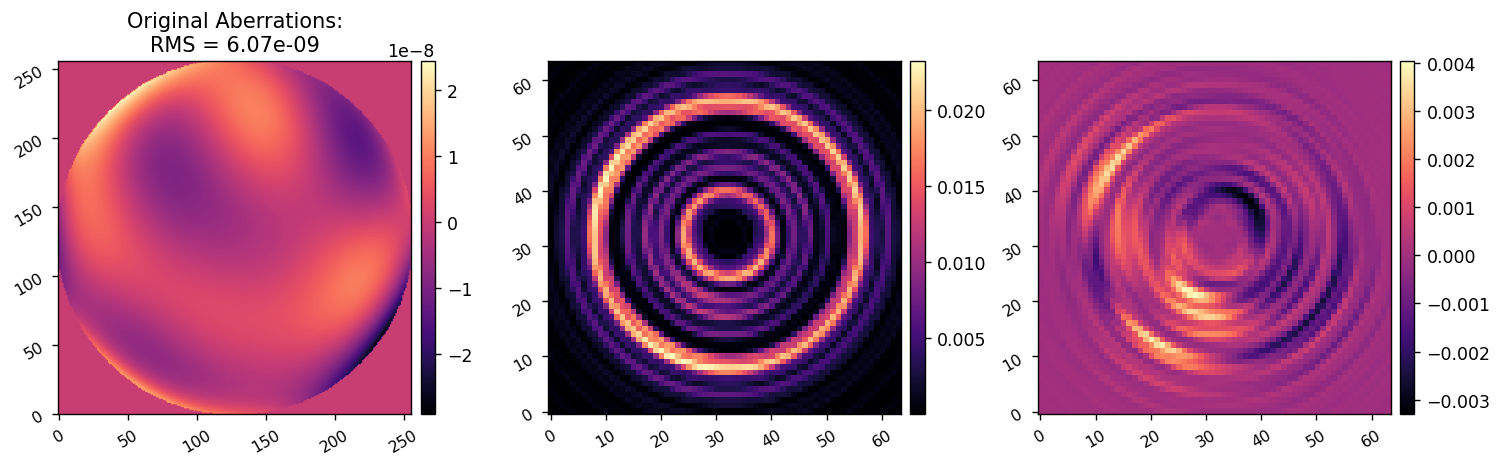

In [29]:
np.random.seed(123)
# amps = 5e-9*(np.random.randn(5))
amps = 1e-9*(np.random.randn(nmodes))

lo_wfe = 0
for i in range(len(amps)):
    lo_wfe += amps[i]*zmodes[i]

rms_lo_err = np.sqrt(np.sum(np.square(amps)))
rms_lo_err = np.sqrt(np.mean(np.square(lo_wfe[pupil_mask])))
print(rms_lo_err)

# model.set_dm(lo_wfe/2)
model.WFE = poppy.ArrayOpticalElement(opd=lo_wfe, pixelscale=model.pupil_diam.to(u.m)/(model.npix*u.pix))
im = model.snap()

diff_im = im - im_ref

imshow3(lo_wfe, im, diff_im,
        f'Original Aberrations:\nRMS = {rms_lo_err:.2e}', )

In [27]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-5)

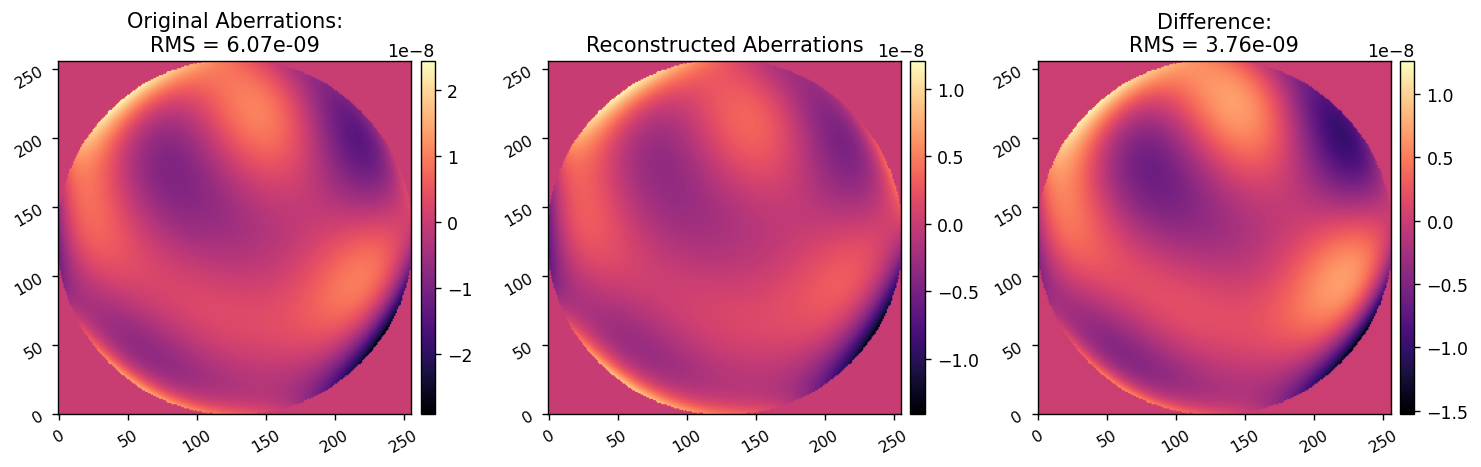

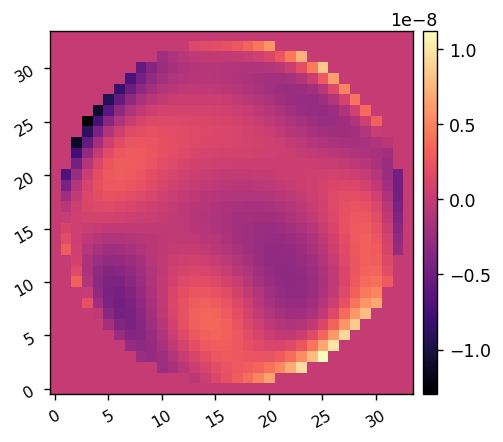

In [30]:
modal_coeff = control_matrix[:len(amps)].dot(diff_im.flatten())

est_lo_wfe = 0
est_correction = 0
for i in range(len(modal_coeff)):
    est_lo_wfe += modal_coeff[i]*zmodes[i]
    est_correction += modal_coeff[i]*dm_zernikes[i]

est_lo_wfe = xp.rot90(xp.rot90(est_lo_wfe))

diff = lo_wfe - est_lo_wfe
rms_residual = np.sqrt(np.mean(np.square(diff[pupil_mask])))

imshow3(lo_wfe, est_lo_wfe, diff, 
        f'Original Aberrations:\nRMS = {rms_lo_err:.2e}', 
        'Reconstructed Aberrations', 
        f'Difference:\nRMS = {rms_residual:.2e}',
        )

imshow1(est_correction)


In [32]:
model.set_dm(est_correction/2)
model

# make a plot for how many modes can be controlled versus the total RMS

In [96]:
U.shape, s.shape, Vt.shape

((4096, 25), (25,), (25, 25))

In [108]:
dm_zernikes[xp.argmax(control_matrix.dot(emode.flatten()))]


NameError: name 'emode' is not defined

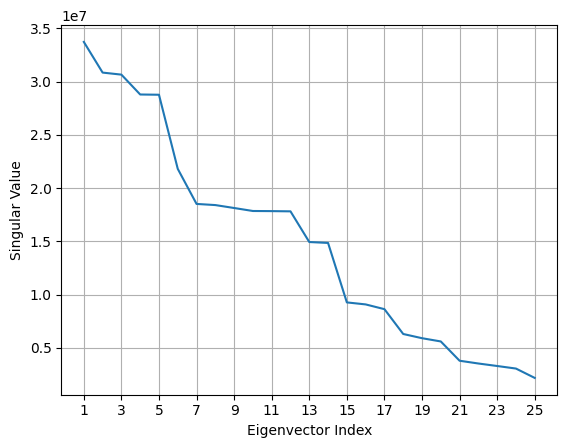

In [132]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)

plt.plot(np.arange(1,nmodes+1), ensure_np_array(s))
plt.xticks(np.arange(1,nmodes+1, 2))
plt.xlabel('Eigenvector Index')
plt.ylabel('Singular Value')
plt.grid()

# for i in range(nmodes):
#     print(s.shape)

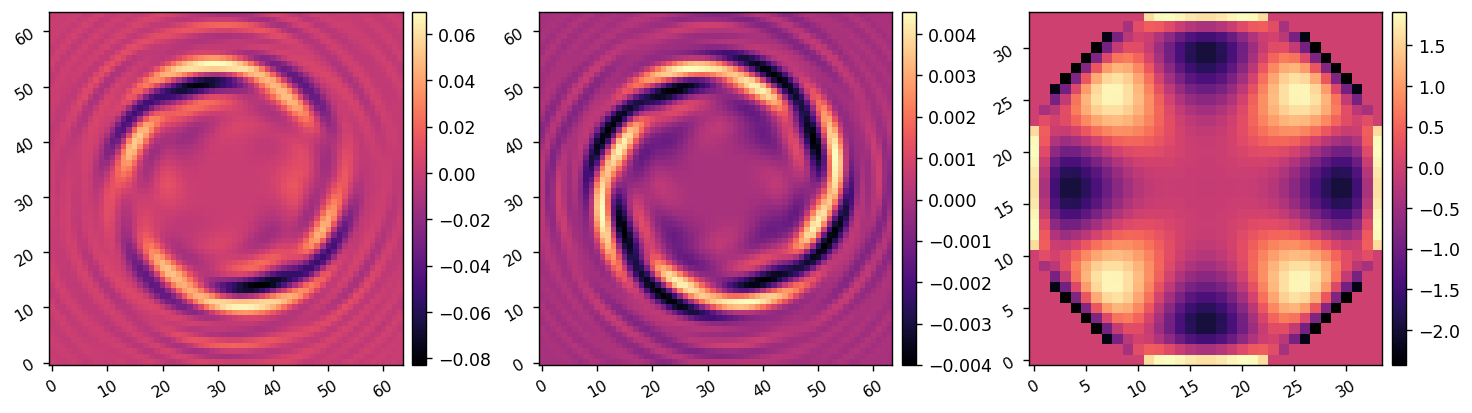

In [117]:
emode = U[:,6].reshape(model.nllowfsc, model.nllowfsc)
best_match = response_matrix.T[xp.argmax(control_matrix.dot(emode.flatten()))].reshape(model.nllowfsc, model.nllowfsc)*amp
best_mode = dm_zernikes[xp.argmax(control_matrix.dot(emode.flatten()))]
imshow3(emode, best_match, best_mode)